# Notebook looking at functional groups/pathways in A. thaliana

In [77]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import time
import math
import sys
import gensim
import os
import warnings
import itertools
from collections import Counter
from inspect import signature
from scipy.stats import ks_2samp
from sklearn.metrics import precision_recall_curve, f1_score, auc
from collections import defaultdict

sys.path.append("../../oats")
from oats.utils.utils import save_to_pickle, load_from_pickle, merge_list_dicts
from oats.datasets.dataset import Dataset
from oats.datasets.groupings import Groupings
from oats.datasets.string import get_stringdb_information
from oats.annotation.ontology import Ontology
from oats.annotation.annotation import write_annotations_to_tsv_file, read_annotations_from_tsv_file
from oats.graphs.pairwise import pairwise_edgelist_doc2vec, pairwise_edgelist_bagofwords, pairwise_edgelist_setofwords
from oats.graphs.pairwise import pairwise_edgelist_annotations, merge_edgelists, subset_edgelist_with_ids
from oats.graphs.pairwise import remove_self_loops
from oats.objectives.functions import balance_classes
from oats.graphs.indexed import IndexedGraph

mpl.rcParams["figure.dpi"] = 200
warnings.simplefilter('ignore')

### Reading in dataset and subsetting based on a functional group dataset

In [80]:
# Reading in the entire dataset, subsetting for Arabidosis and all annotation types.
dataset = load_from_pickle("../data/pickles/full_dataset.pickle")
dataset.describe()
dataset.filter_by_species("ath")
dataset.collapse_by_all_gene_names()
dataset.filter_has_description()
dataset.filter_has_annotation()
dataset.describe()

Number of rows in the dataframe: 47151
Number of unique IDs:            47151
Number of unique descriptions:   16504
Number of unique gene name sets: 47151
Number of species represented:   6
Number of rows in the dataframe: 5972
Number of unique IDs:            5972
Number of unique descriptions:   3635
Number of unique gene name sets: 5972
Number of species represented:   1


In [81]:
# Reading in an object with information about groupings based on groupings from some source (KEGG, etc).
groups = load_from_pickle(path="../data/pickles/lloyd_subsets.pickle")
id_to_group_ids = groups.get_forward_dict(dataset.get_gene_dictionary())
group_mapped_ids = [k for (k,v) in id_to_group_ids.items() if len(v)>0]
dataset.filter_with_ids(group_mapped_ids)
dataset.describe()

Number of rows in the dataframe: 2557
Number of unique IDs:            2557
Number of unique descriptions:   2211
Number of unique gene name sets: 2557
Number of species represented:   1


### Generating the edge list that specifies the graph constructed from text similarity

In [43]:
# Objects and dictionaries needed to build the list of edges for the full graph.
doc2vec_model_filename = "../gensim/enwiki_dbow/doc2vec.bin"
doc2vec_model = gensim.models.Doc2Vec.load(doc2vec_model_filename)
ontology_filename = "../ontologies/mo.obo"
ontology = Ontology(ontology_filename)
descriptions = dataset.get_description_dictionary()
annotations = dataset.get_annotations_dictionary()
# Generating the pairwise edgelist and saving it as a dataframe.
name_to_df_mapping = {}
name_to_df_mapping["doc2vec"] = pairwise_edgelist_doc2vec(doc2vec_model, descriptions)
name_to_df_mapping["bagofwords"] = pairwise_edgelist_bagofwords(descriptions) 
name_to_df_mapping["setofwords"] = pairwise_edgelist_setofwords(descriptions)
name_to_df_mapping["ontology"] = pairwise_edgelist_annotations(annotations, ontology)
df = merge_edgelists(name_to_df_mapping, default_value=0.000)
df = remove_self_loops(df)
print(df.head(8))
print(df.shape[0])

   from  to   doc2vec  bagofwords  setofwords  ontology
1     0   1  0.517816    0.833781    0.971014  0.977578
2     0   2  0.465785    0.750175    0.896774  0.427313
3     0   3  0.490442    1.000000    1.000000  0.844828
4     0   4  0.465889    0.966099    0.947917  0.425439
5     0   5  0.455556    0.708015    0.862745  0.697095
6     0   6  0.388728    0.799200    0.897638  0.399103
7     0   7  0.565127    0.835728    0.915584  0.498099
8     0   8  0.471597    0.846357    0.885714  0.476793
3267846


### Comparing baseline to within-group edge weight distributions

In [44]:
# Obtain the whole-data and within-group edge weight distributions by method.
METHODS = ["doc2vec", "bagofwords", "setofwords", "ontology"]
group_id_to_ids = groups.get_reverse_dict(dataset.get_gene_dictionary())
group_ids = list(group_id_to_ids.keys())
graph = IndexedGraph(df)
within_weights_dict = defaultdict(list)
all_weights_dict = {}
for method in METHODS:
    all_weights_dict[method] = df[method].values
    for group in group_ids:
        within_ids = group_id_to_ids[group]
        within_pairs = [(i,j) for i,j in itertools.permutations(within_ids,2)]
        within_weights_dict[method].extend(graph.get_values(within_pairs, kind=method))

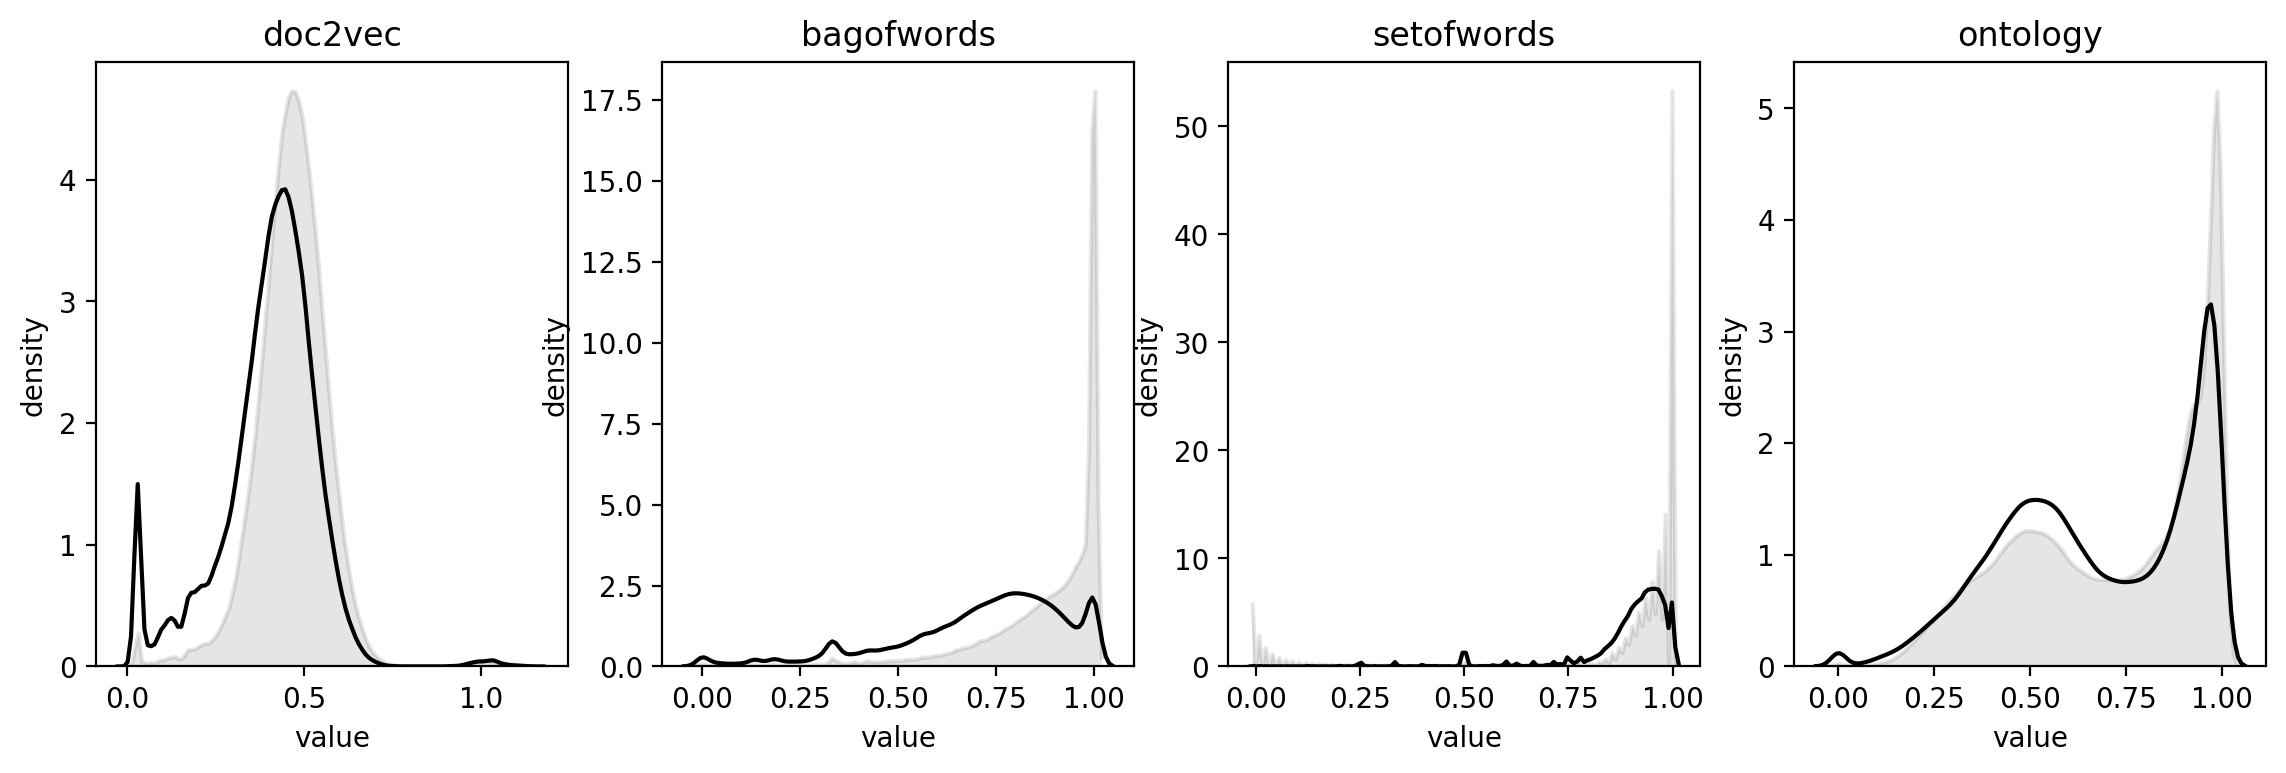

In [45]:
# Plotting the kernel density estimates of the whole-data and within-group distributions.
fig, axs = plt.subplots(1,len(METHODS))
for method,ax in zip(METHODS,axs):
    ax.set_title(method)
    ax.set_xlabel("value")
    ax.set_ylabel("density")
    sns.kdeplot(within_weights_dict[method], color="black", shade=False, alpha=1.0, ax=ax)
    sns.kdeplot(all_weights_dict[method], color="black", shade=True, alpha=0.1, ax=ax) 
fig.set_size_inches(14.0, 4.0)
fig.show()

### Predicting whether two genes share/do not share a functional group or pathway

In [83]:
df.loc[:,"class"] = [int(len(set(id_to_group_ids[id1]).intersection(set(id_to_group_ids[id2])))>0) 
    for (id1,id2) in zip(df["from"].values,df["to"].values)]
print(df.head(8))

   from  to   doc2vec  bagofwords  setofwords  ontology  class
1     0   1  0.517816    0.833781    0.971014  0.977578      0
2     0   2  0.465785    0.750175    0.896774  0.427313      0
3     0   3  0.490442    1.000000    1.000000  0.844828      0
4     0   4  0.465889    0.966099    0.947917  0.425439      0
5     0   5  0.455556    0.708015    0.862745  0.697095      0
6     0   6  0.388728    0.799200    0.897638  0.399103      0
7     0   7  0.565127    0.835728    0.915584  0.498099      0
8     0   8  0.471597    0.846357    0.885714  0.476793      0


                 auc  baseline  n_shared      n_not
doc2vec     0.315500  0.111994  365978.0  2901868.0
bagofwords  0.404853  0.111994  365978.0  2901868.0
setofwords  0.331474  0.111994  365978.0  2901868.0
ontology    0.143809  0.111994  365978.0  2901868.0


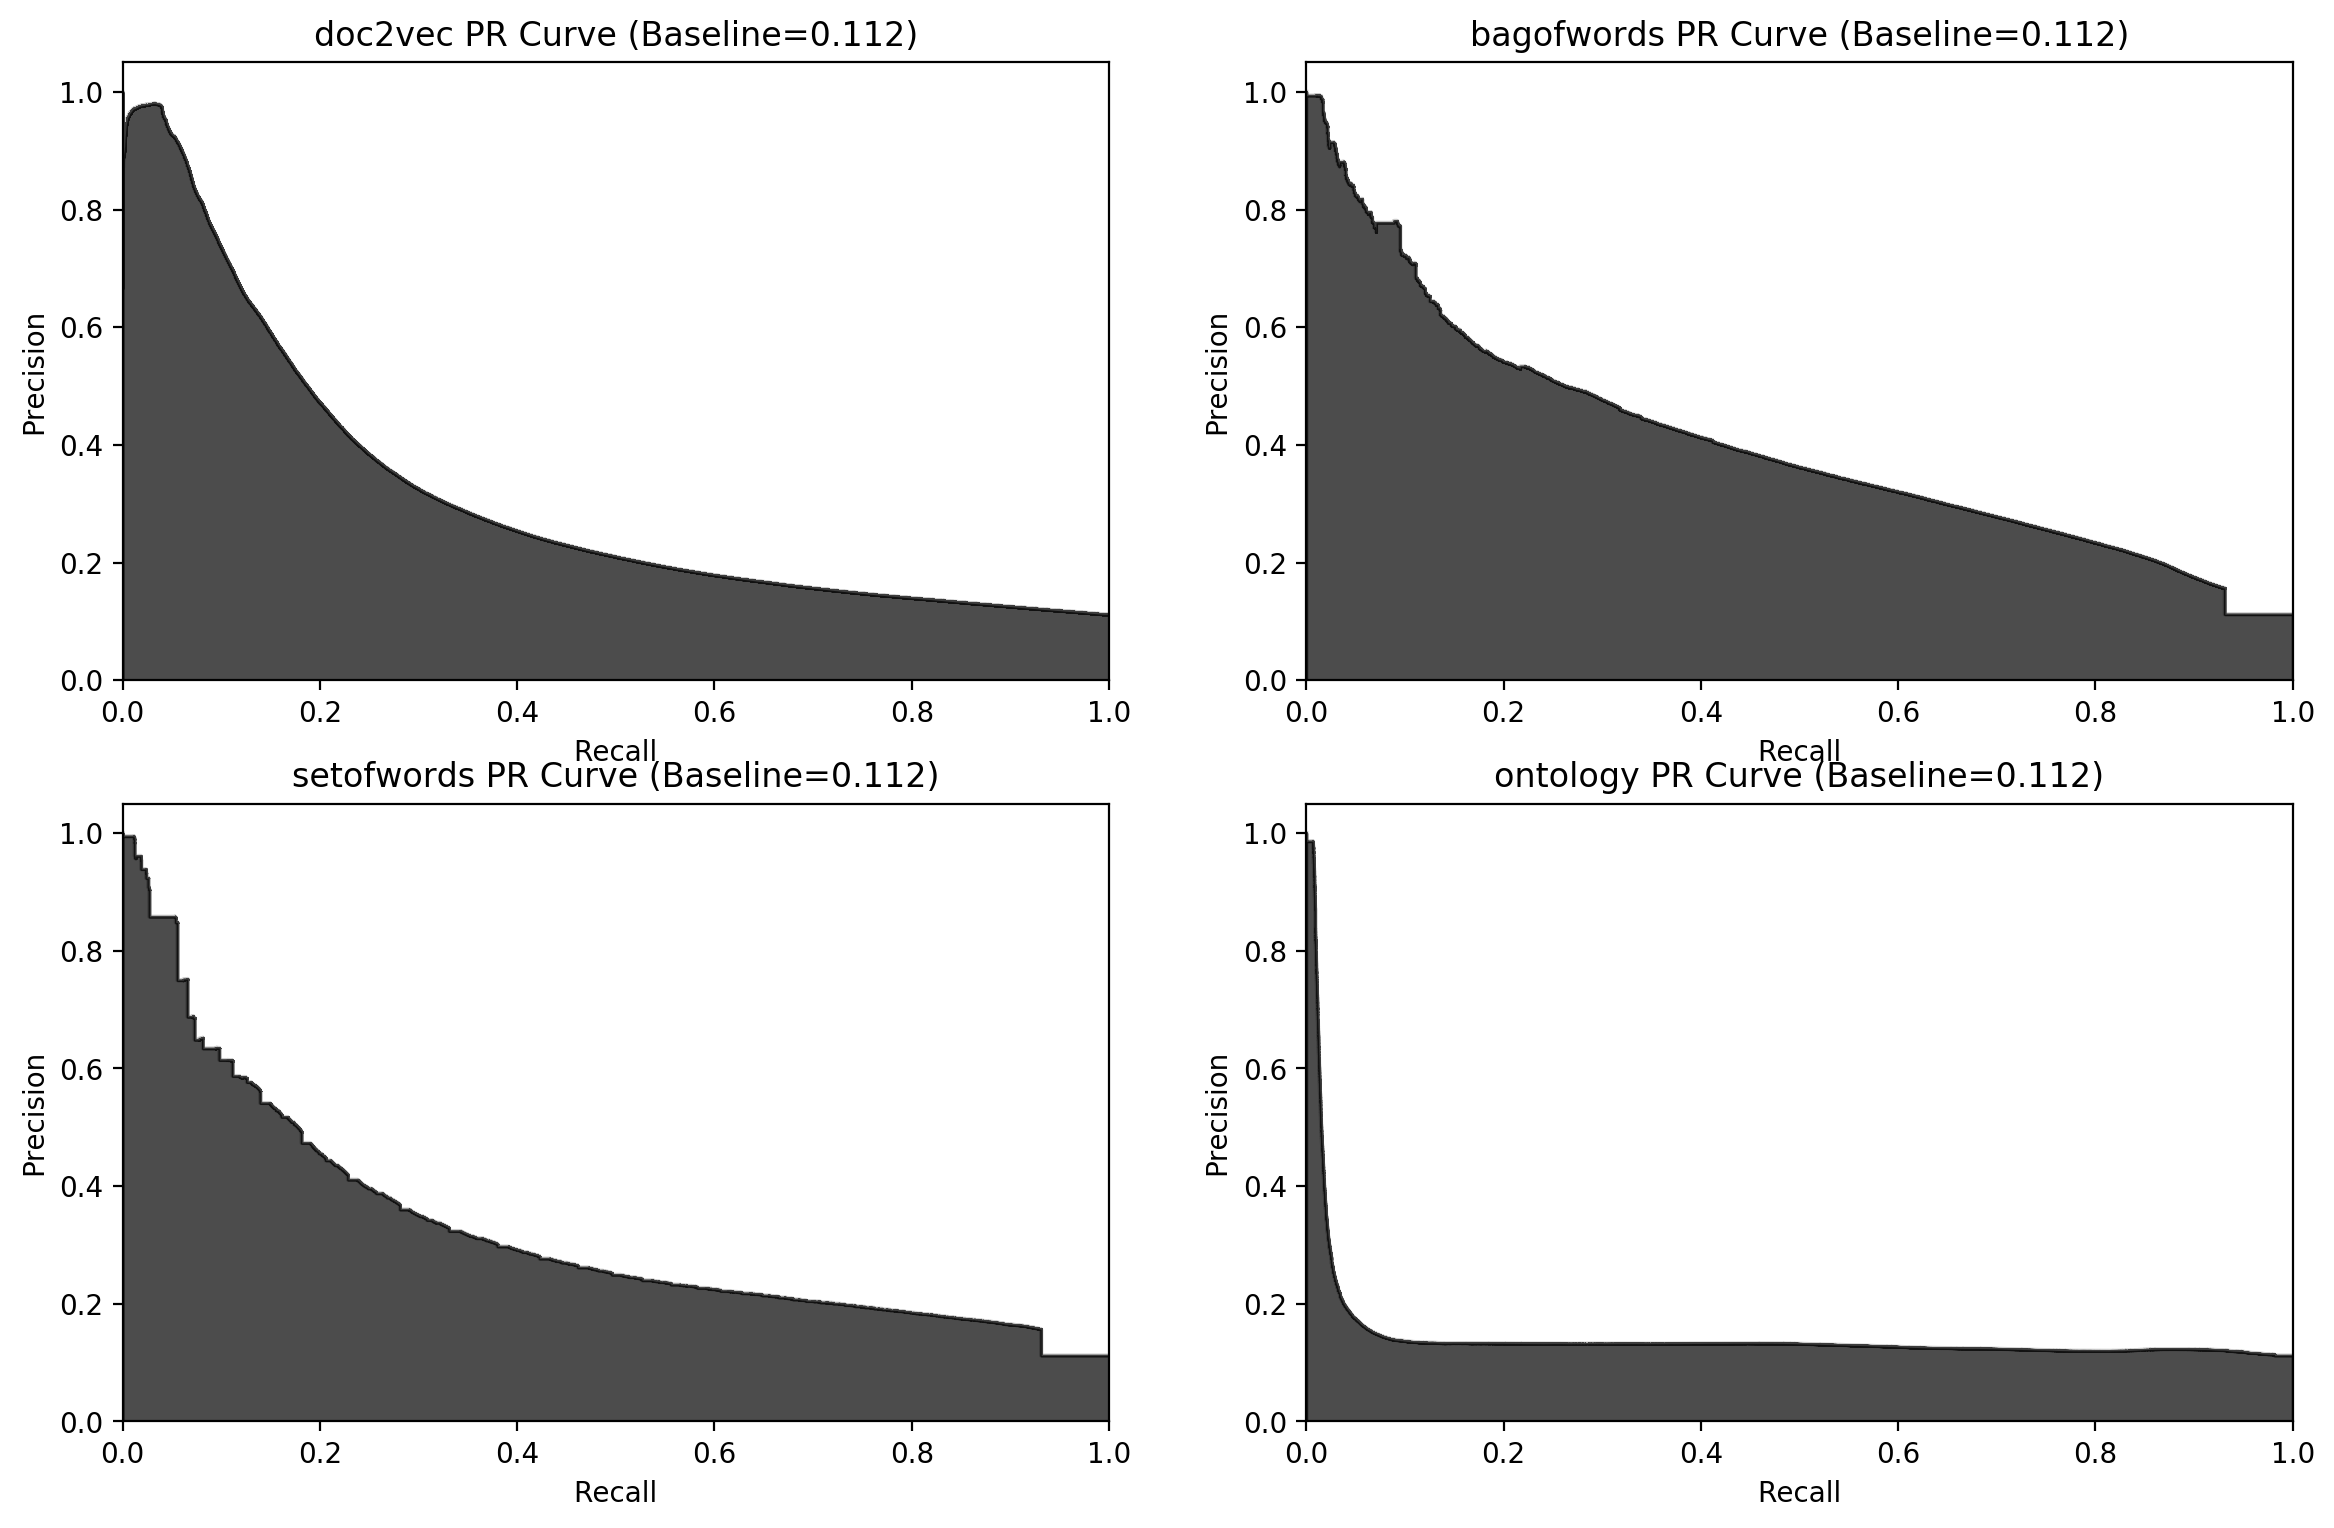

In [86]:
# Generate the targe class values, 1 indicating common function and 0 indicating no common function.
y_true_dict = {name:df["class"] for name in METHODS}
y_prob_dict = {name:(1 - df[name].values) for name in METHODS}
results = {}
num_figure_rows = 2
num_figure_cols = math.ceil(len(METHODS)/num_figure_rows)
fig, axs = plt.subplots(num_figure_rows, num_figure_cols, squeeze=False)
for method,ax in zip(METHODS, axs.flatten()):
    # Obtaining the values and metrics.
    y_true, y_prob = y_true_dict[method], y_prob_dict[method]
    n_pos, n_neg = Counter(y_true)[1], Counter(y_true)[0]
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    baseline = Counter(y_true)[1]/len(y_true) 
    area = auc(recall, precision)
    auc_to_baseline_auc_ratio = area/baseline
    results[method] = {"auc":area, "baseline":baseline, "n_shared":n_pos, "n_not":n_neg}
    # Producing the precision recall curve.
    step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
    ax.step(recall, precision, color='black', alpha=0.2, where='post')
    ax.fill_between(recall, precision, alpha=0.7, color='black', **step_kwargs)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title("{0} PR Curve (Baseline={1:0.3f})".format(method, baseline))
# Report the results and show the precision recall curves.
print(pd.DataFrame(results).transpose())
fig.set_size_inches(14.0, 9.0)
fig.show()